# MNIST Classification

The MNIST dataset is a collection of 70,000 handwritten digits that is commonly used for training various image processing systems. It is a great dataset for beginners to practice image classification tasks.

We will not use Neural Networks, but rather we will see how even traditional machine learning algorithms can perform well on this task.

## Data

We'll use the `fetch_openml` function from the `sklearn.datasets` module to load the MNIST dataset. This function fetches datasets from [OpenML](https://www.openml.org/), a platform for sharing machine learning datasets.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False) # as_frame=False returns data as NumPy arrays

In [2]:
X, y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

As we see:
- the `X` array contains 70,000 images, each with 784 features, which correspond to the 28x28 pixels of each image; each pixel is represented by a grayscale value ranging from 0 to 255;
- the `y` array contains the labels for each image, which are the digits from 0 to 9.

## Train-Test Split
In this phase, we will split the dataset into a set we use to train our model (the training set) and a set we use to evaluate the performance of our final model (the test set). Generally, we would do this using the `train_test_split` function from `sklearn.model_selection`, but in this case, the MNIST dataset is already split into a training set (the first 60,000 images) and a test set (the last 10,000 images).

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Data Exploration and Visualization

Let's plot a sample image from the dataset and its corresponding label to visualize it:

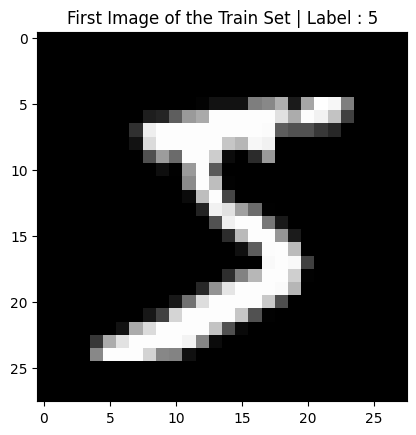

In [4]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.title(f"First Image of the Train Set | Label : {y_train[0]}")
plt.show()

Let's now get a better sense of the distribution of the different digits in the dataset by plotting a bar chart of the counts of each digit in the training set:

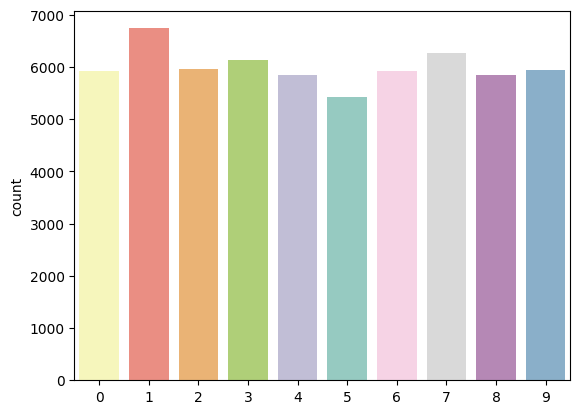

In [5]:
import seaborn as sns

sns.countplot(x=y_train, hue=y_train, palette="Set3", order=sorted(set(y_train)))
plt.show()

The bar chart shows that the dataset is relatively balanced, with each digit having a similar number of samples. This is beneficial for training a classification model, as it helps to prevent bias towards any particular class.

## Data Preprocessing
When working with numerical data, it is often beneficial to scale the features to a standard range. This can help improve the performance of many machine learning algorithms. In this case, we will initialize a `StandardScaler` from `sklearn.preprocessing` to standardize the features by removing the mean and scaling to unit variance:
$$ z = \frac{(x - \mu)}{\sigma} $$


In [6]:
from sklearn.preprocessing import StandardScaler

# Initialize the Scaler for Later
scaler = StandardScaler()

## Training a Classifier
We will now try a bunch of different classifiers to see how well they perform on this task. We will then evaluate the performance of each model: since the dataset is balanced, we will use accuracy as our evaluation metric. We will then try to improve the performance of the best model.

### Logistic Regression
We will start with a simple Logistic Regression model, which estimates the probability of an observation belonging to a class using a sigmoid function.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline([
    ('preprocessor', scaler),
    ('model', LogisticRegression(max_iter=300, random_state=42))
    ])

log_reg.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


Let's now evaluate the model using 5 fold cross-validation:

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_reg, X_train, y_train, cv = 5, scoring='accuracy')
print(f"Logistic Regression Cross-Validated Accuracy: {scores.mean():.2f}")

Logistic Regression Cross-Validated Accuracy: 0.91


We got a good baseline model, with a cross-validated accuracy of 91%.

### KNN Classifier
We now try a K-Nearest Neighbors (KNN) classifier, which is a simple yet effective algorithm for classification tasks. It works by finding the K nearest neighbors to a given data point and assigns the most common class among those neighbors to the data point.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the pipeline
knn = Pipeline([
    ('preprocessor', scaler),
    ('model', KNeighborsClassifier(n_neighbors=5))
    ])

# Evaluation
scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring='accuracy')
print(f"KNN Cross-Validated Accuracy: {scores.mean():.2f}")

KNN Cross-Validated Accuracy: 0.94


This got a cross-validated accuracy of 94%, higher than the Logistic Regression model.

### Random Forest Classifier
Let's now try to fit a RandomForestClassifier: this classifier fits a number of decision trees on various sub-samples of the dataset; it then averages the predictions, usually taking to better accuracy and control of over-fitting than single decision trees.

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the pipeline
rf = Pipeline([
    ('preprocessor', scaler),
    ('model', RandomForestClassifier(random_state=42))
    ])

# Evaluation
scores = cross_val_score(rf, X_train, y_train, cv = 5, scoring='accuracy')
print(f"Random Forest Cross-Validated Accuracy: {scores.mean():.2f}")

Random Forest Cross-Validated Accuracy: 0.97


This got a cross-validated accuracy of 97%, which is the highest we reached till now.

## Analyze the Errors
Since we already have algorithms performing quite well on this task, we won't try others; instead, we will try to understand where these models make the most errors. By checking the type of errors our model is more likely to commit we can try to improve it.

Even if KNN got worse performances than RF, it is way simpler and also way faster, so we will stick with it initially.

### KNN Model Errors

We will check the Confusion Matrix to check if there's any type of error that our model commits more frequently than others; first, let's use the model to make cross-validated predictions on the train set:

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(knn, X_train, y_train, cv = 5)

We then plot the Confusion Matrix (we will normalize the values to allow comparisons):

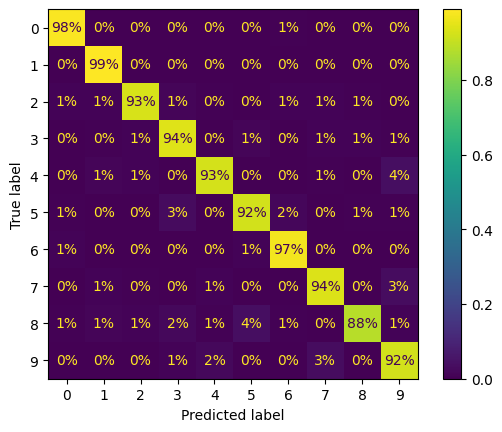

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%')
plt.show()

We can see how the model has hard time in classifying the 8s (only 88% of 8s are correctly classified). Moreover, the misclassification that the KNN model performs the most is classifying some of the 8s as 5s; let's plot some cases of both correctly classified and misclassified 5s and 8s to see if we can spot the reason behind this behavior:

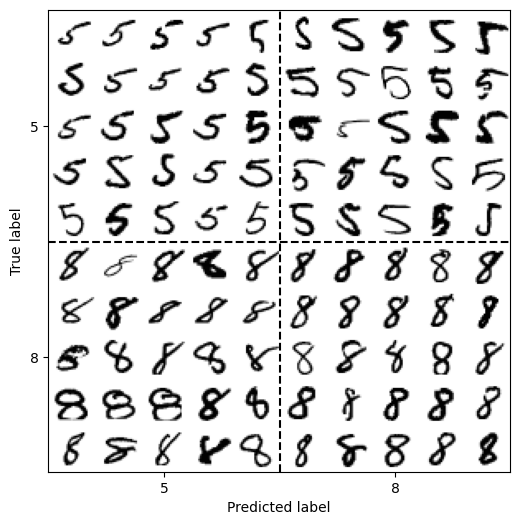

In [ ]:
import numpy as np

def plot_confusion_image_grid(X_aa, X_ab, X_ba, X_bb, cl_a, cl_b, max_images=25):
    fig, ax = plt.subplots(figsize=(6,6))

    # limit images to max_images per cell
    X_aa = X_aa[:max_images]
    X_ab = X_ab[:max_images]
    X_ba = X_ba[:max_images]
    X_bb = X_bb[:max_images]

    # number of rows/cols for grid inside each cell
    def make_mosaic(X):
        if len(X) == 0:
            return np.ones((28, 28)) * 255  # empty white patch
        n = int(np.ceil(np.sqrt(len(X))))
        X = X[:n*n]
        return (X.reshape(n, n, 28, 28)
                 .swapaxes(1, 2)
                 .reshape(n*28, n*28))

    mosaics = [[make_mosaic(X_aa), make_mosaic(X_ab)],
               [make_mosaic(X_ba), make_mosaic(X_bb)]]

    # combine into big confusion matrix grid
    top = np.hstack(mosaics[0])
    bottom = np.hstack(mosaics[1])
    big_grid = np.vstack([top, bottom])

    ax.imshow(big_grid, cmap="binary")
    ax.set_xticks([big_grid.shape[1]//4, 3*big_grid.shape[1]//4], [cl_a, cl_b])
    ax.set_yticks([big_grid.shape[0]//4, 3*big_grid.shape[0]//4], [cl_a, cl_b])
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # draw separators
    ax.axhline(big_grid.shape[0]//2, color="k", linestyle="--")
    ax.axvline(big_grid.shape[1]//2, color="k", linestyle="--")

    plt.show()

cl_a, cl_b = '5', '8'

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plot_confusion_image_grid(X_aa, X_ab, X_ba, X_bb, cl_a, cl_b)

As we see, the bottom-left grid shows how some of these 8s are misleading, so it's not that surprising that KNN isn't able to recognize them. A way to increase the accuracy of our model could be to have more training data to enable the model to learn better patterns. A way of doing this could be applying **Data Augmentation** to create synthetic data.

### Data Augmentation
It reguards a series of techniques to create artificially transformed versions of the training data already in possession, by, for example, rotating, flipping, shifting the original image. This allows to have more data and, most importantly, more diverse data, helping the model to generalize better. Generally, data augmentation is performed in Deep Learning projects, so it is already well implemented in DL frameworks like TensorFlow, Keras and PyTorch. 

Considering the MNIST dataset is a simple and well structured dataset, we can implement our own data augmentation function with scipy and numpy; our function will simply shift the image in each direction by 1 pixel, creating 4 new copies (there's also a parameter to eventually rotate the image, but it has been kept to None to avoid having too much data):

In [12]:
from scipy.ndimage import rotate, shift
import numpy as np

def augment(X, y, pixels_to_shift = None, angle_to_rotate = None):
    aug_images, aug_labels = [], []
    
    for i, img in enumerate(X):
        label = y[i]
        img = img.reshape(28, 28)
        if pixels_to_shift:
            right_shift = np.clip(shift(img, shift = (0, pixels_to_shift), mode='constant', cval=0), 0, 255).astype(np.uint8)
            left_shift = np.clip(shift(img, shift = (0, -pixels_to_shift), mode='constant', cval=0), 0, 255).astype(np.uint8)
            up_shift = np.clip(shift(img, shift = (pixels_to_shift, 0), mode='constant', cval=0), 0, 255).astype(np.uint8)
            down_shift = np.clip(shift(img, shift = (-pixels_to_shift, 0), mode='constant', cval=0), 0, 255).astype(np.uint8)
            aug_images += [right_shift.reshape(784), left_shift.reshape(784), up_shift.reshape(784), down_shift.reshape(784)]
            aug_labels += [label for _ in range(4)]
        if angle_to_rotate:
            c_rotate = np.clip(rotate(img, angle = angle_to_rotate, reshape = False, mode='constant', cval=0), 0, 255).astype(np.uint8)
            cc_rotate = np.clip(rotate(img, angle = angle_to_rotate, reshape = False, mode='constant', cval=0), 0, 255).astype(np.uint8)
            aug_images += [c_rotate.reshape(784), cc_rotate.reshape(784)]
            aug_labels += [label for _ in range(2)]
    
    X_aug = np.array(aug_images)
    y_aug = np.array(aug_labels)
    
    X_combined = np.vstack([X, X_aug])
    y_combined = np.hstack([y, y_aug])
    
    return X_combined, y_combined

Let's plot the first image and the 4 new augmented version we would obtain:

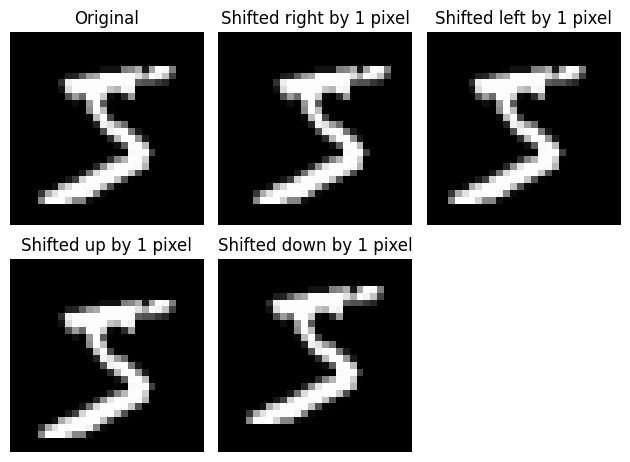

In [13]:
import matplotlib.pyplot as plt

# Augment the first image
X_train0_aug, _ = augment(X_train[[0]], y_train[[0]], pixels_to_shift = 1)

fig, ax = plt.subplots(2, 3)

# Original
ax[0, 0].imshow(X_train0_aug[0].reshape(28, 28), cmap='gray')
ax[0, 0].set_title('Original')
ax[0, 0].axis('off')

# Right-Shift
ax[0, 1].imshow(X_train0_aug[1].reshape(28, 28), cmap='gray')
ax[0, 1].set_title('Shifted right by 1 pixel')
ax[0, 1].axis('off')

# Left-Shift
ax[0, 2].imshow(X_train0_aug[2].reshape(28, 28), cmap='gray')
ax[0, 2].set_title('Shifted left by 1 pixel')
ax[0, 2].axis('off')

# Up-Shift
ax[1, 0].imshow(X_train0_aug[3].reshape(28, 28), cmap='gray')
ax[1, 0].set_title('Shifted up by 1 pixel')
ax[1, 0].axis('off')

# Down-Shift
ax[1, 1].imshow(X_train0_aug[4].reshape(28, 28), cmap='gray')
ax[1, 1].set_title('Shifted down by 1 pixel')
ax[1, 1].axis('off')

# Remove Last Empty Grid
fig.delaxes(ax[1, 2])

plt.tight_layout()
plt.show()

We will now try to re-train our KNN model using Data Augmentation on the training set (to do so we will need to define a custom CV loop to ensure that the Data Augmentation is applied only to the training folds at each iteration and that the model is evaluated on the not augmented original validation set):

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

y_true_all = []
y_pred_all = []

skf = StratifiedKFold(n_splits=5)
for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Augment only training fold
    X_aug_fold, y_aug_fold = augment(X_train_fold, y_train_fold, pixels_to_shift=1)

    # Train on augmented fold, validate on untouched val fold
    knn.fit(X_aug_fold, y_aug_fold)
    y_pred = knn.predict(X_val_fold)

    # Collect predictions and true labels
    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred)

# Evaluation
print(f"KNN with Data Augmentation Cross-Validated Accuracy: {accuracy_score(y_true_all, y_pred_all):.2f}")

KNN with Data Augmentation Cross-Validated Accuracy: 0.96


We went from a 94% cross-validated accuracy to 96%, just by adding 4 copies of each image of the train set, each shifted by one pixel in each direction (this same data augmentation with Random Forest increased computations by a lot, without taking any boost in performances).

## Fine-Tuning the Hyperparameters
We will now find the best possible combination of hyperparameters for our models; to do so we'll use `RandomizedSearchCV`, which iteratively trains different hyperparameter combinations out of the ones we specify, saving the ones yielding best score. Considering this need to re-train models continuosly, we'll start fine-tuning KNN instead of Random Forest considering the huge computational and time gap between these 2:

### KNN Classifier Fine-Tuning

First, let's check the default parameters of our KNN model:

In [29]:
knn['model'].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [30]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2],
    'model__algorithm': ['auto', 'brute'],
    'model__leaf_size': [20, 30, 50]
}

rnd_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42)
rnd_search.fit(X_train, y_train)

print(f"Best params: {rnd_search.best_params_}")
print(f"Best score: {rnd_search.best_score_:.2f}")

Best params: {'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 7, 'model__leaf_size': 30, 'model__algorithm': 'brute'}
Best score: 0.96


We reached a 0.96 cross-validated accuracy (with 3 fold CV) with the above parameters, so +0.02 considering the default parameters (but with 5-fold CV).

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

#knn = rnd_search.best_estimator_

knn = Pipeline([
    ('preprocessor', scaler),
    ('model', KNeighborsClassifier(weights='distance', p = 1, n_neighbors=7, leaf_size=30, algorithm='brute'))
    ])

y_true_all = []
y_pred_all = []

skf = StratifiedKFold(n_splits=5)
for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Augment only training fold
    X_aug_fold, y_aug_fold = augment(X_train_fold, y_train_fold, pixels_to_shift=1)

    # Train on augmented fold, validate on untouched val fold
    knn.fit(X_aug_fold, y_aug_fold)
    y_pred = knn.predict(X_val_fold)

    # Collect predictions and true labels
    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred)
    
# Evaluation
print(f"Fine-Tuned KNN with Data Augmentation Cross-Validated Accuracy: {accuracy_score(y_true_all, y_pred_all):.2f}")

Fine-Tuned KNN with Data Augmentation Cross-Validated Accuracy: 0.97


Nice! With fine-tuning and data augmentation we reached a cross-validated accuracy of 0.97, taking the KNN to perform like the Random Forest! However, this KNN model with Data Augmentation requires almost 10 times more to run on the same data than the Random Forest without Data Augmentation, so we will keep the Random Forest as our final model (still this section highlighted the power of synthetic data).

Random Forest fine-tuning phase increased a lot the computations without yielding any performance boost; given that, the default Random Forest will be kept as final model.

## Final Evaluation on Test Set
We will now retrain our best model on the full training set without cross-validation and test his performances on the held-out test set; as final model, we will use the default Random Forest:

In [16]:
rf

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [19]:
# Training Model on Full Train Set
rf.fit(X_train, y_train)

# Making Predictions on the Held-Out Test Set
y_test_pred = rf.predict(X_test)

# Evaluation on the Held-Out Test Set
score = accuracy_score(y_test, y_test_pred)
print(f"Random Forest Final Test Accuracy: {score:.2f}")

Random Forest Final Test Accuracy: 0.97
